# Intialize

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class as Class_sz

In [2]:
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators and to avoid any ambiguity when comparing with camb. 
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665   
}

# Compute $\rho_c(z)$

In [3]:
%%time 
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':' ',
'skip_background_and_thermo': 0,
'cosmo_model': 0,
})

CPU times: user 187 μs, sys: 1.24 ms, total: 1.43 ms
Wall time: 3.1 ms


True

In [4]:
%%time
classy_sz.compute_class_szfast()

CPU times: user 290 ms, sys: 48.5 ms, total: 338 ms
Wall time: 120 ms


In [5]:
classy_sz.get_rho_crit_at_z(0.)

277517901355.0651

# Conversion to standard units

In [7]:
c_light = 2.997924581e8 # s 
G = 6.674*1e-11 # m3 kg-1 s-2
solar = 1.98855*1e30 ## kg 
mpc = 3.08567758149137*1e22 # m 
gamma =  G/c_light**2*solar/mpc

conv_fac = 1./(1000.*mpc**3/solar)

classy_sz.get_rho_crit_at_z(0.)*conv_fac*classy_sz.h()**2 # g/m^3 

8.598840023056267e-30

# Plot $\rho(z)$

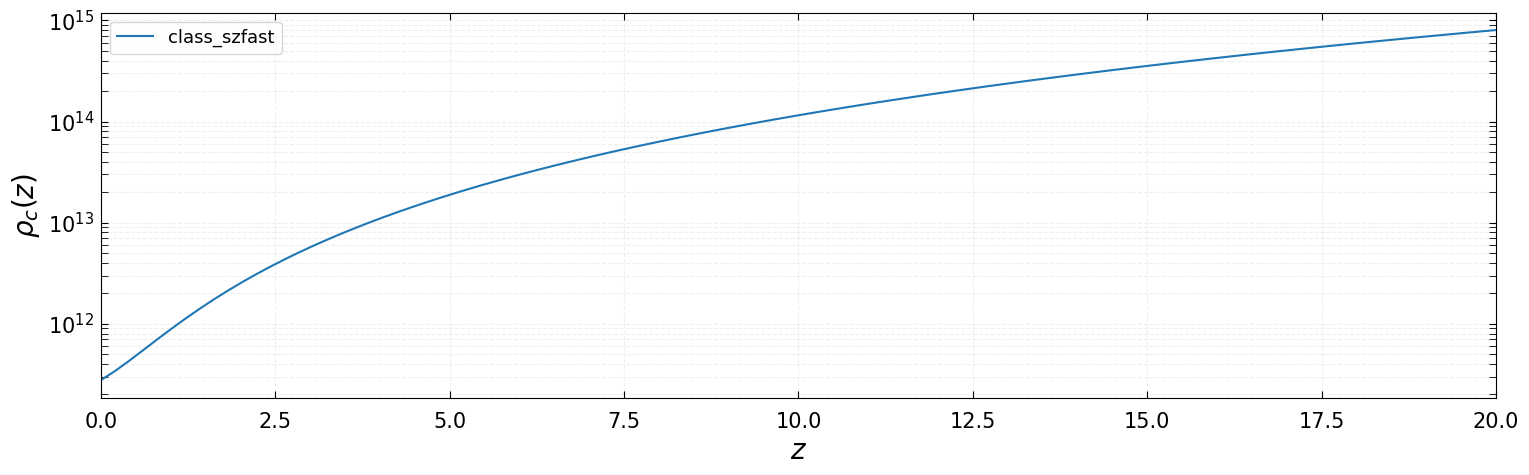

In [8]:
label_size = 15
title_size = 20
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(18,5))

ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')


z = np.linspace(0.,20,100)

ax.plot(z,np.vectorize(classy_sz.get_rho_crit_at_z)(z),ls='-',label='class_szfast')






ax.set_ylabel(r"$\rho_c(z)$",size=title_size)
ax.set_xlabel(r"$z$",size=title_size)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(fontsize=legend_size)



# Compute with Jax

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from classy_sz import Class as Class_sz
import jax.numpy as jnp
from jax import jacfwd

In [2]:
%%time
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,
}

# initialize computation
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':' ',
'jax': 1,
})
classy_sz.compute_class_szfast()

CPU times: user 648 ms, sys: 212 ms, total: 860 ms
Wall time: 1.12 s


In [3]:
zp = 0.1
classy_sz.get_rho_crit_at_z(zp,params_values_dict=cosmo_params)

Array(3.06136466e+11, dtype=float64)

In [4]:
Omega_c = 0.26
z = jnp.linspace(0.1,20.,200)

def rhoc_allzs(Omega_c):
    omega_cdm = Omega_c*(cosmo_params['H0']/100.)**2
    cosmo_params.update({'omega_cdm':omega_cdm})
    rhoc = classy_sz.get_rho_crit_at_z(z,params_values_dict=cosmo_params)
    return rhoc

In [5]:
%%time
drhoc_allzs = jacfwd(rhoc_allzs,argnums=(0))

CPU times: user 37 μs, sys: 4 μs, total: 41 μs
Wall time: 53.2 μs


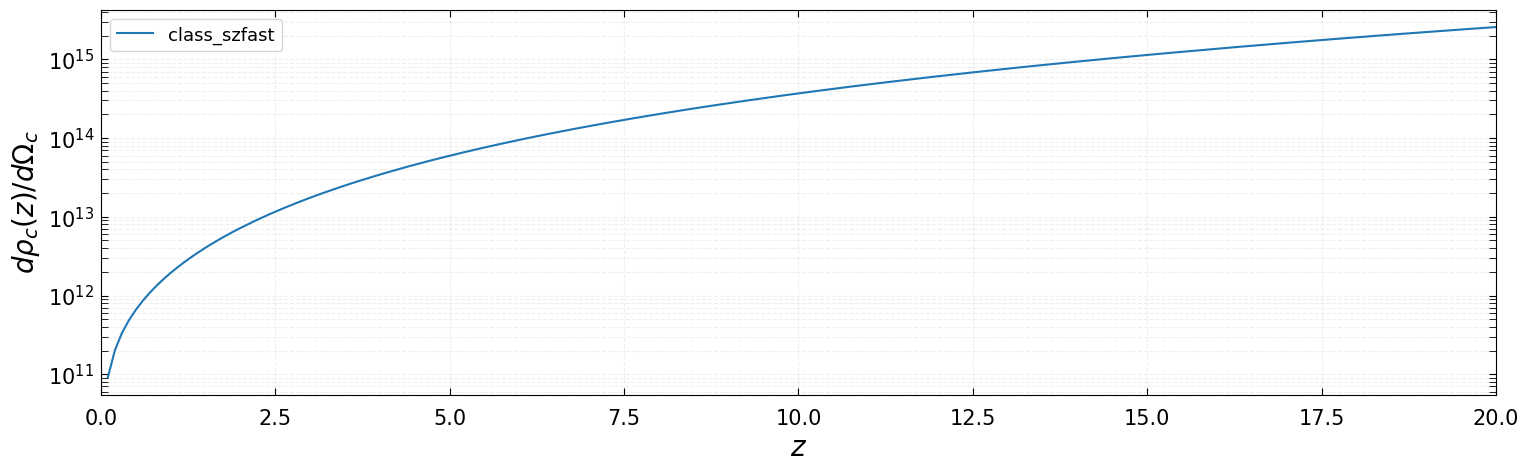

In [6]:
label_size = 15
title_size = 20
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(18,5))

ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')




ax.plot(z,drhoc_allzs(Omega_c),ls='-',label='class_szfast')






ax.set_ylabel(r"$d\rho_c(z)/d\Omega_c$",size=title_size)
ax.set_xlabel(r"$z$",size=title_size)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(fontsize=legend_size)